In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import font_manager
import matplotlib.patheffects as pe


In [2]:
%config InlineBackend.figure_formats = ['svg']
dpi = 300
matplotlib.rcParams['figure.dpi']= dpi

pd.set_option('display.max_rows', 200)

figsize = (8, 5)
matplotlib.rcParams['figure.figsize'] = figsize

# plot parameters

blue = '#3C608A'
lightgray = '#d3d8d6'
darkblue = '#2e4465'
darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'
mustard = '#D4AD50'
purple = '#5E233B'
pink = '#F87FAB'



fe = font_manager.FontEntry(
    fname= 'bpc_fonts/Redesign-3/Styrene/StyreneA-Black.otf',
    name='StyreneABlack')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname= 'bpc_fonts/Redesign-3/Styrene/StyreneA-Medium.otf',
    name='StyreneAMedium')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='bpc_fonts/Redesign-3/Styrene/StyreneA-Regular.otf',
    name='StyreneARegular')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

matplotlib.rcParams['font.family'] = 'StyreneARegular' # = 'your custom ttf font name'

ms = 5 # markersize

data_label_fontsize = 9.5



In [3]:
df = pd.read_csv('data/vv_capture_2025-07-23_14-12-58/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# Non-VVSG equipment
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable',
                        'Internet Voting: Email',
                        'Internet Voting: Web Portal',
                        'Internet Voting: Fax',
                        'Remote Ballot Marking System: Client-Side',
                        'Remote Ballot Marking System: Server-Side']

# VVSG equipment
voting_equipment = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            # 'Mechanical Lever Machine',
                            # 'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment)]

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'
df['Manufacturer + Model'] = df['Manufacturer'] + ' ' + df['Model']


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/1615899295.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/vv_capture_2025-07-23_14-12-58/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


In [4]:
# add 2028 assuming no change
df26 = df[df['Year'] == 2026]

df28 = df26.copy()
df28['Year']=2028
df28['Years in Use'] = df28['Years in Use'] + 2
df28['New Equipment'] = False
df = pd.concat([df, df28], ignore_index=True)

In [5]:
df[df['Equipment Type']=='Hybrid BMD/Tabulator']['Model'].value_counts()

Model
ExpressVote XL           90
ExpressVote Tabulator    67
PopulexSlate              1
Name: count, dtype: Int64

In [6]:
df[df['Equipment Type']=='Hybrid Optical Scan/BMD']['Model'].value_counts()

Model
ImageCast Evolution    4646
Name: count, dtype: Int64

In [7]:
df[df['Equipment Type']=='Hybrid Optical Scan/DRE']['Model'].value_counts()

Model
eScan A/T                 693
ImageCast Precinct ATI      2
Name: count, dtype: Int64

In [8]:
# take care of hybrids
df.loc[df['Equipment Type'].str.contains('Hybrid BMD/Tabulator'), 'Equipment Type'] = 'Ballot Marking Device'
df.loc[df['Equipment Type'].str.contains('Hybrid Optical Scan/BMD'), 'Equipment Type'] = 'Hand-Fed Optical Scanner'
df.loc[df['Equipment Type'].str.contains('Hybrid Optical Scan/DRE'), 'Equipment Type'] = 'Hand-Fed Optical Scanner'


In [9]:
# estimate equipment quantities from EAVS data

# load equipment-per-voter rates, computed in cost_analysis.ipynb
per_voter_rates = pd.read_csv('data/equipment_per_voter_rates_by_marking_method.csv', index_col=0)
per_voter_rates

,dre_wo_vvpat_total,dre_w_vvpat_total,bmd_total,hand_fed_total,batch_fed_total
Election Day Marking Method,,,,,
Ballot Marking Devices for all voters,0.000012,0.000036,0.002672,0.000482,0.000009
DREs with VVPAT for all voters,0.000000,0.002704,0.000020,0.000008,0.000007
DREs without VVPAT for all voters,0.003137,0.000000,0.000000,0.000002,0.000000
Hand marked paper ballots and BMDs,0.000001,0.000002,0.000493,0.000520,0.000012
Hand marked paper ballots and DREs with VVPAT,0.000000,0.001078,0.000556,0.000000,0.000000
Hand marked paper ballots and DREs without VVPAT,0.000580,0.000000,0.000000,0.000601,0.000166
"Hand marked paper ballots, BMDs and DREs with VVPAT",0.000000,0.000237,0.000450,0.000470,0.000018
"Hand marked paper ballots, BMDs and DREs without VVPAT",0.000230,0.000000,0.001671,0.000246,0.000005
Hand marked paper ballots; Direct recording assistive interface without VVPAT for accessibility,0.000000,0.000000,0.000000,0.000846,0.000002


In [10]:
q = df.drop_duplicates(subset=['FIPS code', 'Year', 'Equipment Type'], keep='first')

# 1) Decide which per-voter-rate column each row should use
base_map = {
    "Ballot Marking Device": "bmd_total",
    "Hand-Fed Optical Scanner": "hand_fed_total",
    "Batch-Fed Optical Scanner": "batch_fed_total",
}

is_dre = q["Equipment Type"].eq("DRE")
method_lower = q["Election Day Marking Method"].fillna("").str.lower()

# DRE: default to wo_vvpat unless the method explicitly includes "with VVPAT"
with_vvpat = (q['Equipment Type']=='DRE') & q['Election Day Marking Method'].str.contains('DREs with VVPAT')

rate_col = q["Equipment Type"].map(base_map)                       # non-DRE mappings
rate_col = rate_col.mask(is_dre, "dre_wo_vvpat_total")             # DRE default
rate_col = rate_col.mask(with_vvpat, "dre_w_vvpat_total")          # DRE with VVPAT override

# 2) Reshape per_voter_rates so we can join on (Election Day Marking Method, rate_col)
pvr_long = (
    per_voter_rates
      .reset_index(names=["Election Day Marking Method"])
      .melt(id_vars="Election Day Marking Method",
            var_name="rate_col",
            value_name="per_voter_rate")
)


# 3) Merge and compute Quantity (unknowns become 0)
q_with_rates = (
    q.assign(rate_col=rate_col)
     .merge(pvr_long, on=["Election Day Marking Method", "rate_col"], how="left")
)

q_with_rates["per_voter_rate"] = q_with_rates["per_voter_rate"].fillna(0)
q_with_rates["Quantity"] = q_with_rates["Registered Voters"].fillna(0) * q_with_rates["per_voter_rate"]

# keeping only original columns + Quantity:
df = q_with_rates[q.columns.tolist() + ["Quantity"]]



In [11]:
# show model counts by category

# Count per Manufacturer + Model
counts = (
    df26.groupby(['Equipment Type', 'Manufacturer + Model'])
      .size()
      .reset_index(name='count')
)

# Total per Equipment Type
totals = counts.groupby('Equipment Type')['count'].sum().reset_index(name='total')

# Sort by total then breakdown counts
counts = counts.merge(totals, on='Equipment Type')
counts = counts.sort_values(['total', 'count', 'Manufacturer + Model'], ascending=[False, False, True])

# Build list with header rows inserted
rows = []
for etype, group in counts.groupby('Equipment Type', sort=False):
    total = group['total'].iloc[0]
    rows.append({'Equipment Type': f'=== {etype} (Total: {total}) ===', 'Manufacturer + Model': '', 'count': ''})
    rows.extend(group[['Equipment Type', 'Manufacturer + Model', 'count']].to_dict('records'))

# Create final DataFrame for display
final_df = pd.DataFrame(rows)
final_df


,Equipment Type,Manufacturer + Model,count
0,=== Ballot Marking Device (Total: 5009) ===,,
1,Ballot Marking Device,ES&S ExpressVote,2681
2,Ballot Marking Device,Democracy Live OmniBallot Tablet,542
3,Ballot Marking Device,ES&S AutoMARK,410
4,Ballot Marking Device,Dominion ImageCast X BMD,384
5,Ballot Marking Device,Hart InterCivic Verity Touch Writer,184
6,Ballot Marking Device,Hart InterCivic Verity Duo,181
7,Ballot Marking Device,Unisyn OpenElect FVT,175
8,Ballot Marking Device,IVS Inspire Ballot Marking System,169
9,Ballot Marking Device,Clear Ballot ClearAccess,108


In [12]:
# set quantity floor of 0 (it is okay to do this because jurisdictions actually must own at least one piece of equipment to be in the VV dataset)
df['Quantity'] = df['Quantity'].clip(lower=1)

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/1876045910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quantity'] = df['Quantity'].clip(lower=1)


## Histogram of equipment age (weighted by equipment counts)

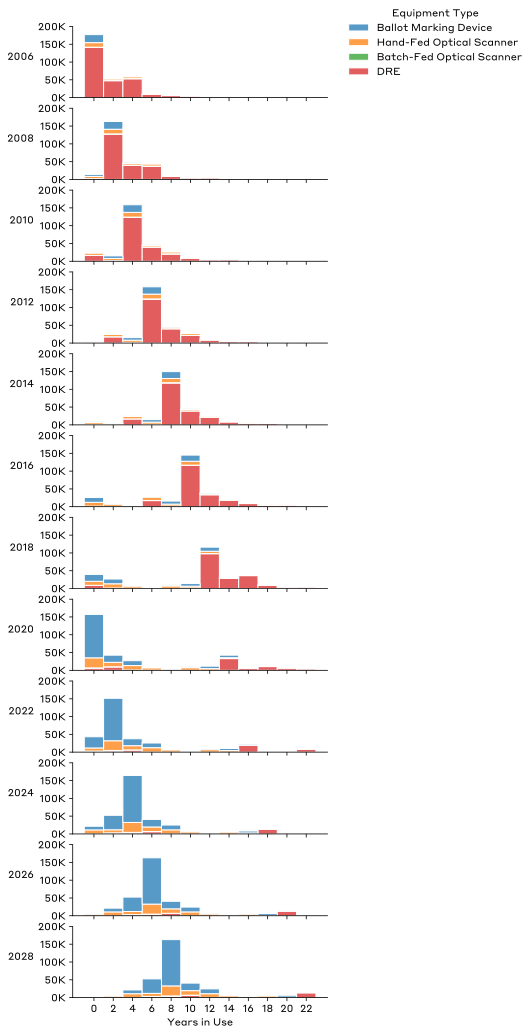

In [13]:
bins=np.arange(0,26,2)
midpoints = (bins[:-1] + bins[1:]) // 2
g = sns.displot(data=df, row='Year', x='Years in Use', kind='hist', height=1.2, aspect=4, bins=list(bins), weights='Quantity', hue='Equipment Type', multiple='stack', edgecolor='white')
g.legend.set_loc('upper right')

for ax in g.axes:
    ax = ax[0]
    ax.set_yticks(np.linspace(0, 2e5, 5))
    ax.set_xticks(midpoints)
    ax.set_xticklabels(bins[:-1], color='black')
    ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')
    ax.set_ylabel(ax.title.get_text()[-4:], rotation=0, ha='right')
    ax.set_title('')  # Remove the title
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))


plt.subplots_adjust(hspace=0.15)


# Average age of equipment in 2026 (weighted by equipment count)

In [14]:
voting_df_26 = df[df["Year"] == 2026]

state_eq_len = (
    voting_df_26
    .groupby("State")
    .apply(lambda g: (g["Years in Use"] * g["Quantity"]).sum() / g["Quantity"].sum(), include_groups=False)
    .reset_index(name="Weighted Years in Use")
).sort_values(['Weighted Years in Use'], ascending=False)

state_eq_len.to_csv('data/weighted_avg_equipment_age_by_state_2026.csv', index=False)
state_eq_len.round(1).head(5)



,State,Weighted Years in Use
19,Louisiana,23.8
38,Oklahoma,14.0
41,Puerto Rico,13.9
36,Northern Mariana Islands,13.2
15,Indiana,13.2


In [15]:
voting_df_26.sort_values('Years in Use', ascending=False).head(20)

,Year,FIPS code,State,Jurisdiction,Registered Voters,Equipment Type,Manufacturer,Model,First Year in Use,Years in Use,...,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage,Precincts,Voting Location,All Mail Ballot?,Election Day Marking Method,Election Day Tabulation,Manufacturer + Model,Quantity
30005,2026,2209700000,Louisiana,St. Landry Parish,58117,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,94,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,182.307
29125,2026,2201700000,Louisiana,Caddo Parish,157089,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,149,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,492.771896
30071,2026,2210300000,Louisiana,St. Tammany Parish,195588,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,170,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,613.539265
29719,2026,2207100000,Louisiana,Orleans Parish,270591,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,351,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,848.815895
30269,2026,2212100000,Louisiana,West Baton Rouge Parish,18208,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,35,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,57.116607
29499,2026,2205100000,Louisiana,Jefferson Parish,274468,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,273,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,860.977642
29301,2026,2203300000,Louisiana,East Baton Rouge Parish,293637,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,328,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,921.108806
29147,2026,2201900000,Louisiana,Calcasieu Parish,128659,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,123,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,403.589935
29895,2026,2208700000,Louisiana,St. Bernard Parish,27440,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,31,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,86.076433
28949,2026,2200100000,Louisiana,Acadia Parish,39352,DRE,Sequoia,AVC Advantage,1998,28,...,False,False,<NA>,47,Assigned Polling Place,False,DREs without VVPAT for all voters,DRE,Sequoia AVC Advantage,123.443141


In [16]:
# of voters per piece of equipment.
voting_df_26.groupby('State')['Registered Voters'].sum().div(voting_df_26.groupby('State')['Quantity'].sum(), axis=0).sort_values(ascending=False).apply(int)

State
Oregon                      7151
Washington                  3931
Guam                        3927
Colorado                    3867
Northern Mariana Islands    3653
Nebraska                    3430
Alaska                      3404
Montana                     3272
New Mexico                  3228
South Dakota                3220
Arizona                     3126
Florida                     2947
District of Columbia        2927
Hawaii                      2926
Minnesota                   2827
Rhode Island                2810
Maryland                    2727
New York                    2698
North Dakota                2686
Iowa                        2638
Michigan                    2619
Virginia                    2549
Illinois                    2462
Missouri                    2434
Alabama                     2431
Massachusetts               2296
Oklahoma                    2278
Idaho                       2240
North Carolina              2126
Kentucky                    2100
Miss

# Do larger jurisdictions have newer equipment?
No. Analysis below.

In [17]:
avg = (
    voting_df_26
    .groupby("FIPS code")
    .apply(lambda g: pd.Series({
        "Registered Voters": g["Registered Voters"].mean(),
        "Years in Use": np.average(g["Years in Use"], weights=g["Quantity"])
    }))
    .reset_index()
)
avg

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/3482874311.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,FIPS code,Registered Voters,Years in Use
0,0100100000,41791.0,8.104371
1,0100300000,180929.0,8.995600
2,0100500000,15697.0,8.104371
3,0100700000,14304.0,5.026093
4,0100900000,41203.0,8.104371
...,...,...,...
6368,5604500000,3426.0,6.000000
6369,6600000000,62091.0,5.873496
6370,6900000000,18401.0,13.205898
6371,7200000000,1987317.0,13.895629


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/382879481.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/382879481.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')


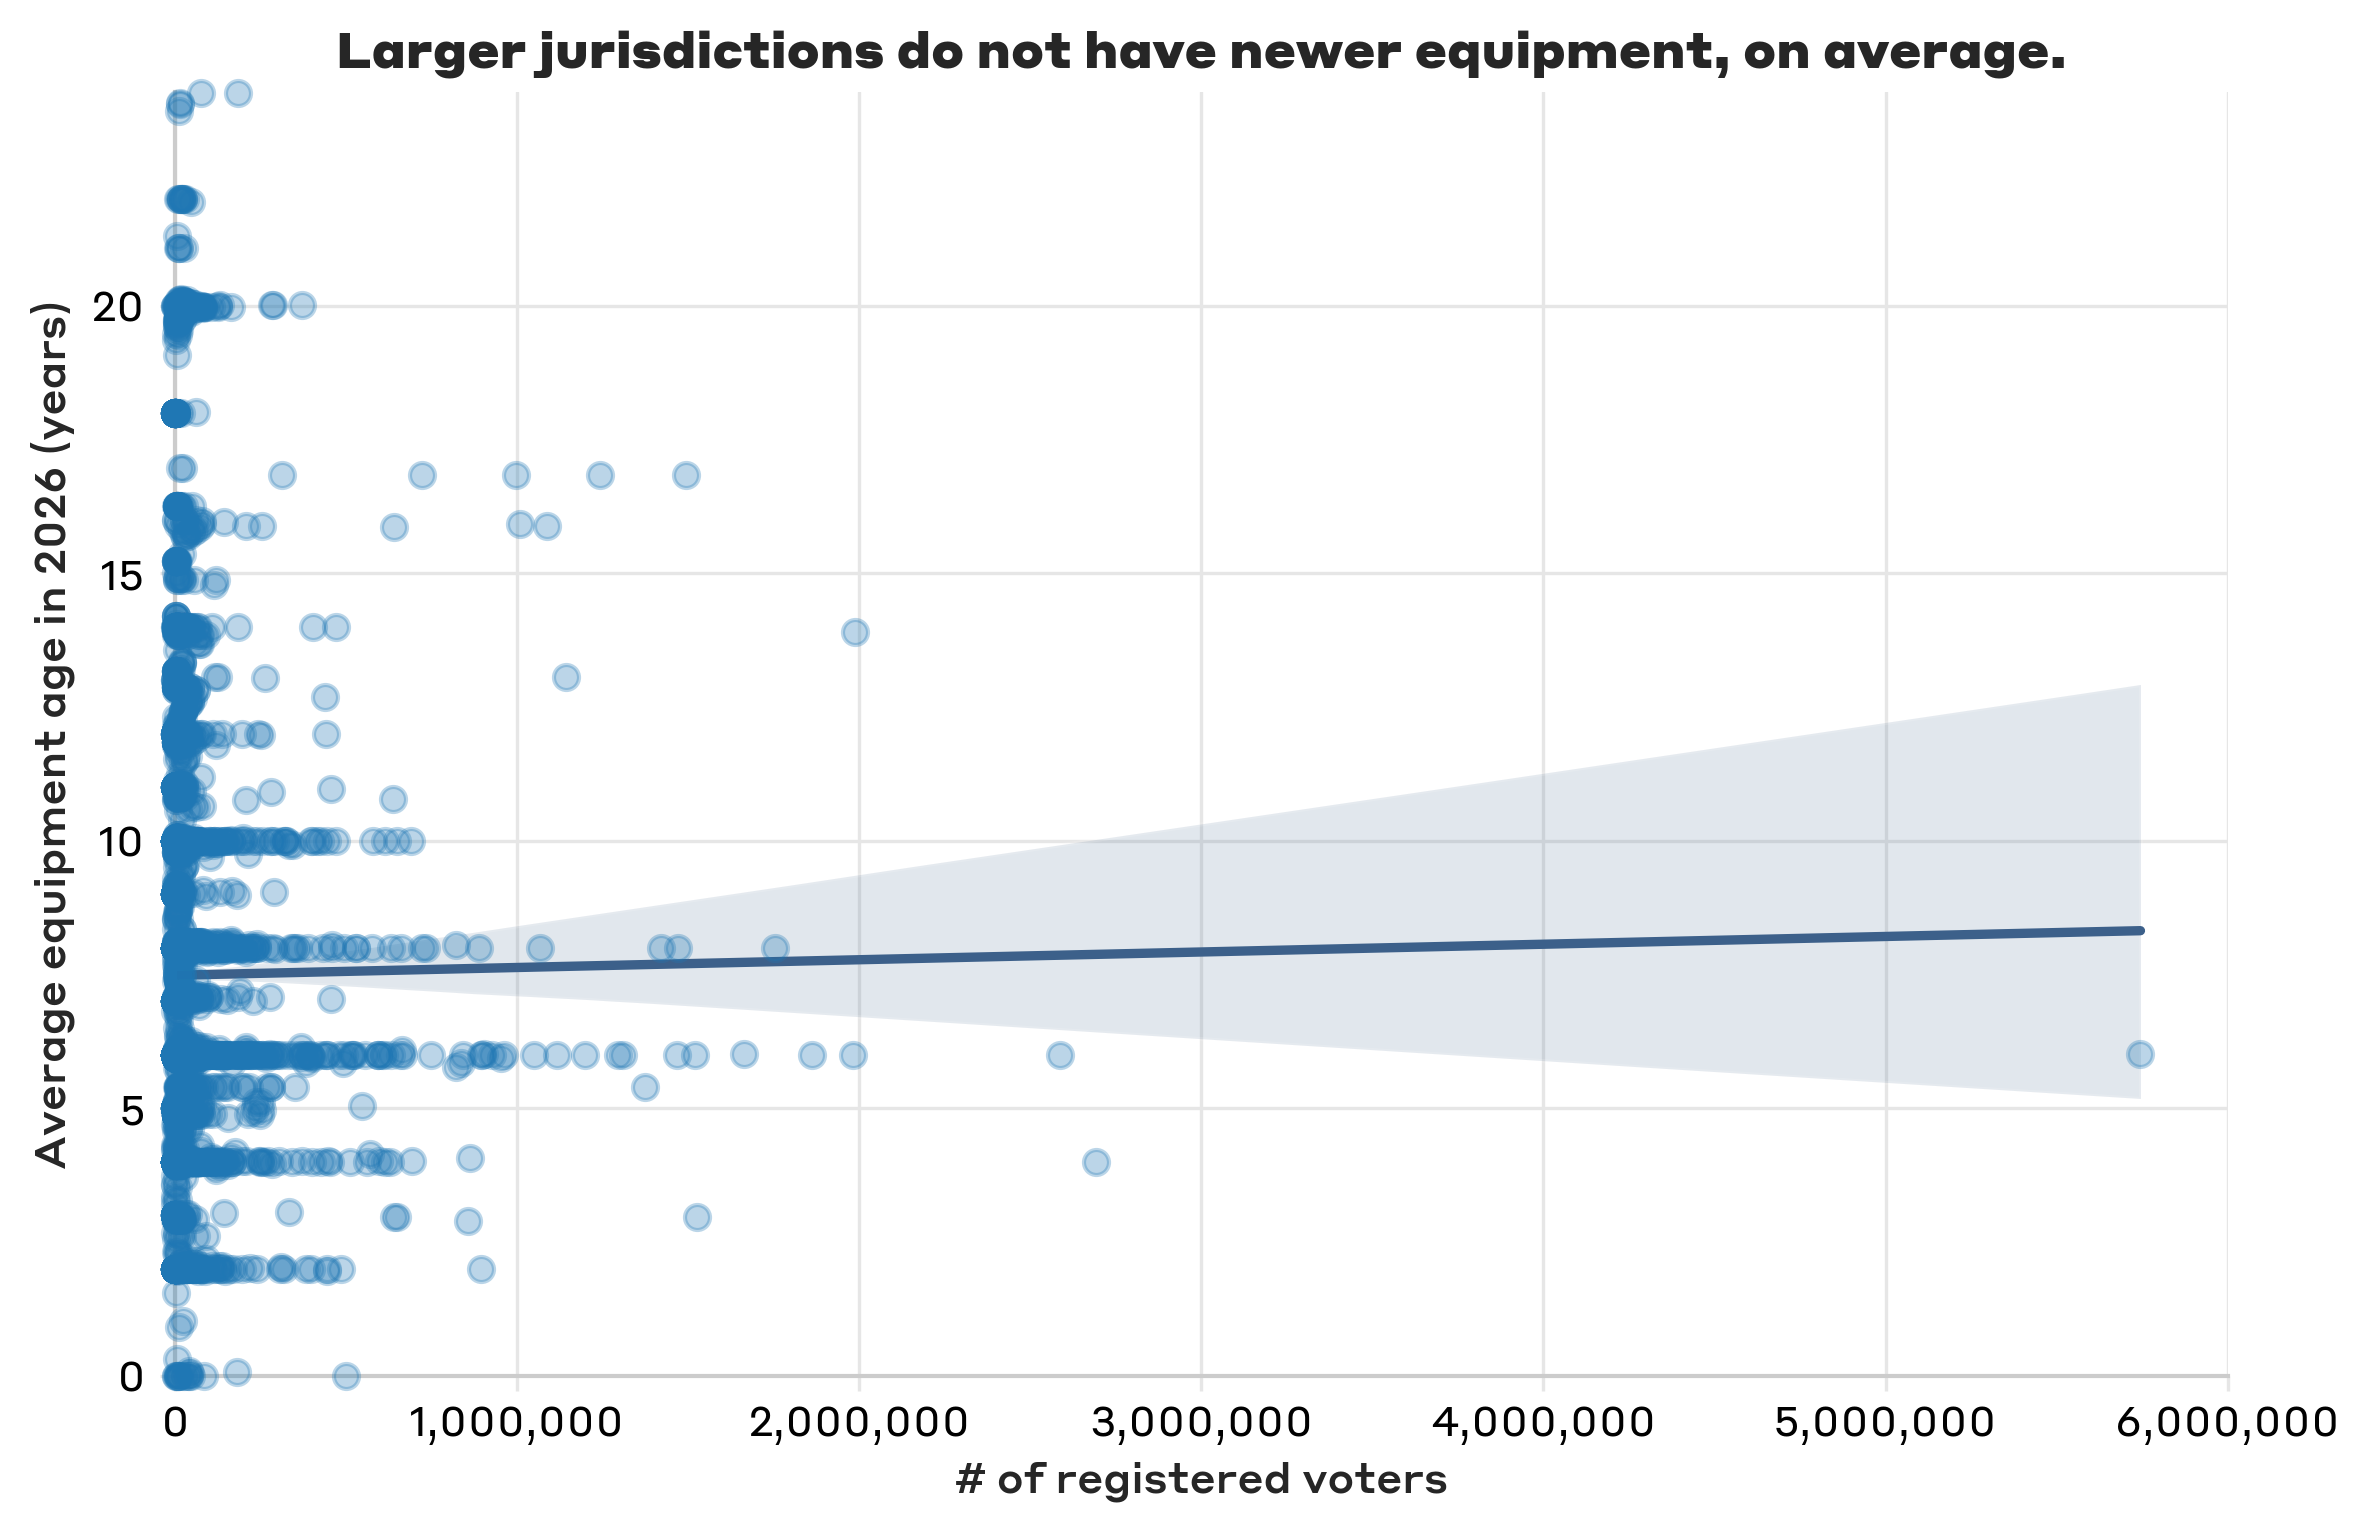

In [18]:
%config InlineBackend.figure_formats = ['png']

# Set up the plot style
axis_width = 1
sns.set_style("whitegrid", {"grid.color": ".9",
                            "font.family": "StyreneARegular",
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'xtick.bottom': True,
                            'ytick.left': True,
                            'xtick.color': '.9',
                            'ytick.color': '.9'})
# Create the scatterplot with regression line
# plt.figure(figsize=figsize)
ax = sns.regplot(
    data=avg,
    x="Registered Voters",
    y="Years in Use",
    scatter_kws={"alpha": 0.3, 'clip_on': False, 'zorder': 10},
    line_kws={"color": blue},
    ci=95,  # Confidence interval for regression line
)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(axis_width)

plt.xlabel("# of registered voters", fontname='StyreneAMedium')
plt.ylabel("Average equipment age in 2026 (years)", fontname='StyreneAMedium')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlim([0, 6e6])
plt.ylim([0, 24])
ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')
plt.tight_layout()
plt.title("Larger jurisdictions do not have newer equipment, on average.", fontname='StyreneABlack');
plt.savefig('figs/age_vs_jurisdiction_size.png', bbox_inches='tight', dpi=300)

In [47]:
avg.iloc[:, 1:].to_csv('data/equipment_ages_by_registered_voters.csv')

# Age of equipment over time

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/4177747409.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')


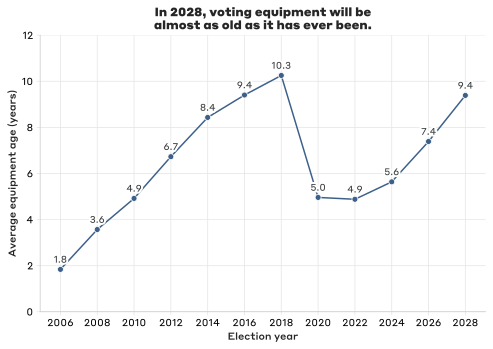

In [19]:
# Compute weighted average years in use per year
filtered_voting_df = df.dropna(subset=["Years in Use", "Registered Voters", 'Quantity'])

years_in_use = (
    filtered_voting_df.groupby("Year")
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Quantity"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)

# Plot
%config InlineBackend.figure_formats = ['svg']

sns.lineplot(data=years_in_use, x="Year", y="Weighted Years in Use", marker="o",
        linestyle="-", color=blue, linewidth=1.5)

ax = plt.gca()

# Add data labels
for i, value in enumerate(years_in_use["Weighted Years in Use"]):
    ax.text(years_in_use["Year"][i], value +0.2, f"{value:.1f}", ha="center", va="bottom",
            fontsize=data_label_fontsize, color=darkgray,
            path_effects=[pe.withStroke(linewidth=4, foreground='white')])

# Formatting
ax.set_ylabel("Average equipment age (years)", fontname='StyreneAMedium')
ax.set_xlabel("Election year", fontname='StyreneAMedium')
ax.set_title("In 2028, voting equipment will be\nalmost as old as it has ever been.", fontname='StyreneABlack')

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")
ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')
plt.ylim(0, 12)
plt.savefig("figs/weighted_avg_years_in_use_over_time.png", bbox_inches='tight', dpi=300)
plt.show()


In [20]:
years_in_use

,Year,Weighted Years in Use
0,2006,1.838658
1,2008,3.567498
2,2010,4.917841
3,2012,6.728580
4,2014,8.431037
5,2016,9.403669
6,2018,10.253012
7,2020,4.960473
8,2022,4.880268
9,2024,5.637076


In [21]:
filtered_voting_df['Equipment Type'].value_counts()

Equipment Type
Hand-Fed Optical Scanner     54265
Ballot Marking Device        47830
DRE                          22986
Batch-Fed Optical Scanner    13991
Name: count, dtype: Int64

(0.0, 50.0)

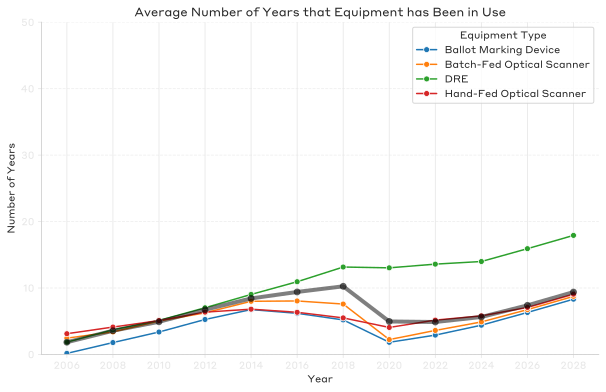

In [22]:
# same as above, but with breakout by equipment type

years_in_use = (
    filtered_voting_df.groupby("Year")
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Quantity"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)


years_in_use_breakout = (
    filtered_voting_df.groupby(['Year', 'Equipment Type'])
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Quantity"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)

# Plot with seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, data=years_in_use_breakout, x='Year', y='Weighted Years in Use', hue='Equipment Type', marker='o')

ax.plot(years_in_use["Year"], years_in_use["Weighted Years in Use"], marker="o", linestyle="-", color='black', linewidth=4, alpha=0.5)

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 50)

# try to understand this better. DREs got younger in 2020 because old ones were decommissioned?


In [23]:
# Split out just the rows with New Equipment = True
new_eq = df[df['New Equipment'] == True].copy()

# Create a shifted Year column for lookup
new_eq['Prev Year'] = new_eq['Year'] - 2

# Merge with the original dataframe to find matches from two years earlier
merged = pd.merge(
    new_eq,
    df,
    left_on=['State', 'Jurisdiction', 'Model', 'Prev Year'],
    right_on=['State', 'Jurisdiction', 'Model', 'Year'],
    suffixes=('_new', '_prev')
)

# Optional: select only columns of interest
result = merged[[
    'State', 'Jurisdiction', 'Model',
    'Year_prev', 'New Equipment_prev',
    'Year_new', 'New Equipment_new'
]]

# Sort or inspect
result = result.sort_values(by=['State', 'Jurisdiction', 'Model', 'Year_new'])


## Compare age of current equipment to typical age at retirement (weighted by quantity)

In [25]:
reference_year = 2028

# Function to calculate weighted average and weighted std
def weighted_stats(group):
    weights = group["Quantity"]
    values = group["Years in Use"]
    
    # Weighted average
    avg = np.average(values, weights=weights)
    
    # Weighted standard deviation
    variance = np.average((values - avg)**2, weights=weights)
    std_dev = np.sqrt(variance)

    N_equipment = sum(weights)
    N_rows = len(weights)
    
    return pd.Series({
        "Weighted Avg Age": avg,
        "Weighted Std Age": std_dev,
        "N Equipment": N_equipment,
        "N Rows": N_rows
    })



# Apply function by Equipment Type
age_at_retirement = filtered_voting_df[filtered_voting_df['Final Year in Use']==True].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()


filtered_voting_df[filtered_voting_df['Final Year in Use']==True].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()


# View result
age_at_retirement

current_age = filtered_voting_df[filtered_voting_df['Year'] == reference_year].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

retirement_df = pd.merge(current_age, age_at_retirement, on='Equipment Type', how='left', suffixes=(' Current', ' At Retirement'))
retirement_df = retirement_df.loc[[2, 0, 1, 3]].reset_index(drop=True)
retirement_df.round(1)


,Equipment Type,Weighted Avg Age Current,Weighted Std Age Current,N Equipment Current,N Rows Current,Weighted Avg Age At Retirement,Weighted Std Age At Retirement,N Equipment At Retirement,N Rows At Retirement
0,DRE,17.9,8.1,32082.8,349.0,9.6,6.0,343049.1,4305.0
1,Ballot Marking Device,8.3,2.9,227343.8,5030.0,9.0,4.9,36727.8,3541.0
2,Batch-Fed Optical Scanner,8.7,3.0,2745.4,1556.0,9.2,4.8,3664.0,1299.0
3,Hand-Fed Optical Scanner,9.1,4.1,88161.6,5332.0,9.6,5.2,57143.4,5989.0


In [26]:
np.average(filtered_voting_df[filtered_voting_df['Year'] == reference_year]['Years in Use'],
           weights=filtered_voting_df[filtered_voting_df['Year'] == reference_year]['Quantity'])

# average current equipment age

np.float64(9.38690792223452)

In [27]:
total_weighted_avg = np.average(retirement_df["Weighted Avg Age At Retirement"], 
                                weights=retirement_df["N Equipment At Retirement"])

print(total_weighted_avg) # average overall retirement age


9.580631515035217


In [28]:
retirement_df['delta'] = retirement_df['Weighted Avg Age Current'] - retirement_df['Weighted Avg Age At Retirement']

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/37422101.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), color='black')


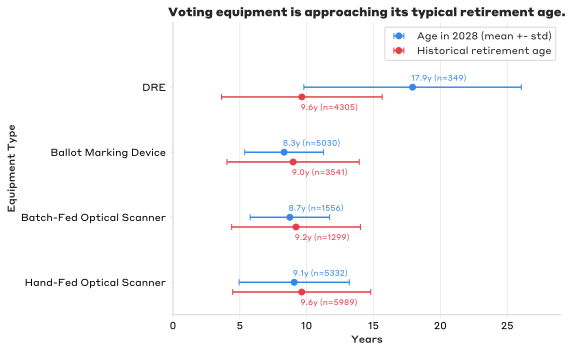

In [29]:
fig, ax = plt.subplots()
y = np.arange(len(retirement_df))

# Plot current age
ax.errorbar(retirement_df['Weighted Avg Age Current'], y, xerr=retirement_df['Weighted Std Age Current'],
            fmt='o', color=lightblue, label=f'Age in {reference_year} (mean +- std)', capsize=3,
            linewidth=1.5)

# Annotate current age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age Current']:.1f}y (n={int(row['N Rows Current'])})"
    ax.text(row['Weighted Avg Age Current'] - 0.1, y[i] - 0.1, label, color=lightblue, fontsize=8)

# Plot retirement age
for i, row in retirement_df.iterrows():
    if pd.notnull(row['Weighted Avg Age At Retirement']):
        label = 'Historical retirement age' if i == 0 else ''
        ax.errorbar(row['Weighted Avg Age At Retirement'], y[i] + 0.15,
                    xerr=row['Weighted Std Age At Retirement'], fmt='o', label=label,
                    color=red, capsize=3)

# Annotate retirement age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age At Retirement']:.1f}y (n={int(row['N Rows At Retirement'])})"
    ax.text(row['Weighted Avg Age At Retirement'] - 0.1, y[i] + 0.35, label, color=red, fontsize=8)


# Formatting
ax.set_yticks(y)
ax.set_yticklabels(retirement_df['Equipment Type'], color='black')
ax.set_xticklabels(ax.get_xticklabels(), color='black')
ax.set_xlim([0, 29])
ax.invert_yaxis()  # So first row is on top
ax.set_xlabel('Years', fontname='StyreneAMedium')
ax.set_ylabel('Equipment Type', fontname='StyreneAMedium')
ax.set_ylim([3.5, -1])
ax.set_title('Voting equipment is approaching its typical retirement age.', fontname='StyreneABlack')
ax.grid(True, axis='x')
ax.grid(False, axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figs/avg_age_and_retirement_age.png', bbox_inches='tight', dpi=300)

# NOTE THAT DOTS INDICATE DATA POINTS, NOT QUANTITIES


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_16925/2323497599.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')


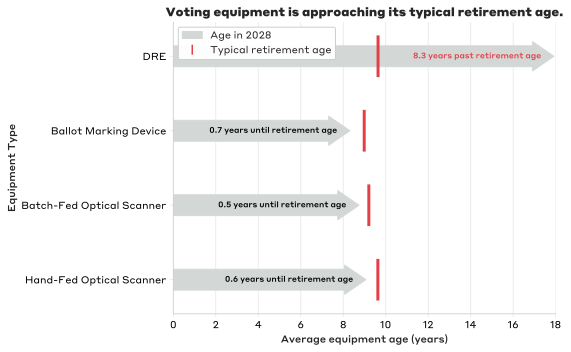

In [43]:
fig, ax = plt.subplots()

bar_width = 0.56
x = np.arange(len(retirement_df))

# Plot bars
# age_bars = ax.barh(x - bar_width/2, retirement_df["Weighted Avg Age Current"], height=bar_width, label="Age in 2026",
#                    color=lightgray)
# retirement_bars = ax.barh(x, retirement_df["Weighted Avg Age At Retirement"], height=bar_width, label="Retirement Age",
#                           color=lightblue)

for i, row in retirement_df.iterrows():
    # Arrow for "Age in 2026" (gray)
    arrow = ax.arrow(
        0,                             # start x
        i,                             # start y
        row["Weighted Avg Age Current"],  # length in x direction
        0,                             # no vertical displacement
        width=bar_width * 0.5,         # "fatness" of shaft
        head_width=bar_width * 0.7,    # arrowhead width
        head_length=1,                 # arrowhead length in data coords
        fc=lightgray, ec=lightgray,
        length_includes_head=True,
        label=f'Age in {reference_year}' #if i == 0 else None
    )
    
    # Arrow for "Retirement Age" (blue)
    # ax.arrow(
    #     0,
    #     i + bar_width/2,
    #     row["Weighted Avg Age At Retirement"],
    #     0,
    #     width=bar_width * 0.8,
    #     head_width=bar_width * 1.2,
    #     head_length=2,
    #     fc=lightblue, ec=lightblue,
    #     length_includes_head=True
    # )


ax.vlines(
    x=retirement_df["Weighted Avg Age At Retirement"],  # x-position of the line
    ymin=x - bar_width/2,  # bottom of the line
    ymax=x + bar_width/2,  # top of the line
    color=red,
    label="Typical retirement age",
    linewidth=3
)

# Annotate differences
for i, row in retirement_df.iterrows():
    # Determine which is smaller to anchor the label
    end_x  = row["Weighted Avg Age Current"]
    y = i

    delta = row["Weighted Avg Age Current"] - row["Weighted Avg Age At Retirement"]

    if delta < 0:
        color = 'black'
    else:
        color = red
    
    ax.annotate(
        f"{abs(delta):.1f} years {'past' if delta > 0 else 'until'} retirement age",
        xy=(end_x-0.6, y),
        ha='right', va='center',
        fontsize=8,
        color=color,
        fontname='StyreneAMedium',
        # bbox=dict(boxstyle="round,pad=0.2", edgecolor='gray', facecolor='white', alpha=0.7)
    )

from matplotlib import lines
vertical_line = lines.Line2D([], [], color=red, marker='|', linestyle='None',
                          markersize=10, markeredgewidth=1.5, label='Typical retirement age')



# Formatting
ax.set_yticks(x)
ax.set_yticklabels(retirement_df["Equipment Type"], color='black')
ax.set_xlim([0, 18])
ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
ax.invert_yaxis()
ax.set_xlabel("Average equipment age (years)", fontname='StyreneAMedium')
ax.set_ylabel("Equipment Type", fontname='StyreneAMedium')
ax.set_title("Voting equipment is approaching its typical retirement age.", fontname='StyreneABlack')



ax.legend(handles=[arrow, vertical_line], loc='upper left',framealpha=0.95)
ax.grid(False, axis='y')
ax.grid(True, axis='x')

plt.tight_layout()
plt.savefig('figs/avg_age_and_retirement_age_small.png', bbox_inches='tight', dpi=300)

In [34]:
retirement_df[['Equipment Type', 'Weighted Avg Age Current', 'Weighted Avg Age At Retirement', 'delta']]

,Equipment Type,Weighted Avg Age Current,Weighted Avg Age At Retirement,delta
0,DRE,17.917711,9.639755,8.277956
1,Ballot Marking Device,8.314874,8.988132,-0.673258
2,Batch-Fed Optical Scanner,8.742959,9.205364,-0.462405
3,Hand-Fed Optical Scanner,9.066992,9.630573,-0.563580


# New equipment acquisitions

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_5327/4071115075.py:11: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.lineplot(
/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_5327/4071115075.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=plt.gca().get_yticklabels(), color='black')


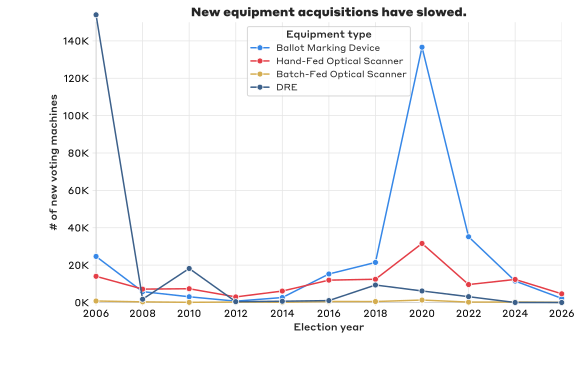

In [ ]:
# Group by year and equipment type, summing Quantity instead of row count
df_grouped = (
    df[(df['New Equipment'])]
    .groupby(['Year', 'Equipment Type'])['Quantity']
    .sum()
    .reset_index(name='Quantity')
)

palette = [lightblue, red, mustard, blue, lightgray, pink, purple, darkblue]

ax = sns.lineplot(
    data=df_grouped,
    x='Year', y='Quantity',
    hue='Equipment Type',
    marker='o', linewidth=1.5,
    palette=palette,
    hue_order=[
        'Ballot Marking Device',
        'Hand-Fed Optical Scanner',
        'Batch-Fed Optical Scanner',
        'DRE',
    ],
    clip_on=False,
    zorder=10
)


ax.legend(
    title="Equipment type",
    title_fontproperties={'family': 'StyreneAMedium', 'size': 10},
    fontsize=9,
    loc='upper center'

)
ax.set_title('New equipment acquisitions have slowed.', fontname='StyreneABlack')
ax.set_xlabel('Election year', fontname='StyreneAMedium')
ax.set_ylabel('# of new voting machines', fontname='StyreneAMedium')
ax.set_xticks(sorted(df['Year'].unique()))
ax.set_xticklabels(labels=plt.gca().get_xticklabels(), color='black')
ax.set_xlim([2006, 2026])
ax.set_ylim([0, 150e3])
ax.set_yticklabels(labels=plt.gca().get_yticklabels(), color='black')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/new_equipment_acquisitions_by_type.png', bbox_inches='tight', dpi=300)

# lots of states (GA and SC) and counties (in CA and TX) went BMD for all in 2020.

In [ ]:
df_grouped.pivot(index="Year", columns="Equipment Type", values="Quantity").reset_index().rename_axis(None, axis=1)

# # If you want a clean index/columns
# wide_df = wide_df


,Year,Ballot Marking Device,Batch-Fed Optical Scanner,DRE,Hand-Fed Optical Scanner
0,2006,24661.789797,814.316267,153946.403932,14016.458123
1,2008,5821.743245,347.938653,1765.297249,7164.279431
2,2010,3069.503962,104.67557,18208.592096,7371.524134
3,2012,722.916142,258.024343,448.176747,2993.927389
4,2014,2658.585162,161.382221,676.210492,6136.089296
5,2016,15264.440025,546.54947,1032.796748,11963.757859
6,2018,21446.585603,523.166228,9356.827494,12446.488505
7,2020,136608.497325,1319.149357,6174.850791,31607.771848
8,2022,35171.102487,225.465802,3124.783241,9612.473018
9,2024,11467.693383,270.287604,7.0,12341.277731


(2006.0, 2026.0)

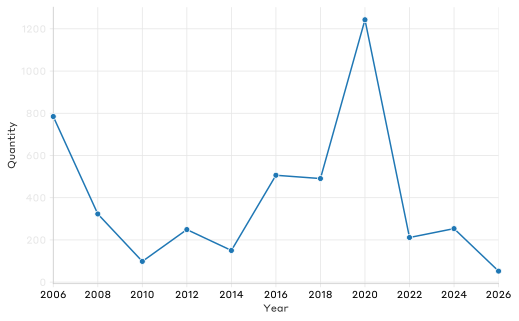

In [ ]:
# batch-fed only
ax = sns.lineplot(
    data=df_grouped[df_grouped['Equipment Type']=='Batch-Fed Optical Scanner'],
    x='Year', y='Quantity',
    marker='o', linewidth=1.5,
    clip_on=False,
    zorder=10
)
ax.set_xticks(sorted(df['Year'].unique()))
ax.set_xticklabels(labels=plt.gca().get_xticklabels(), color='black')
ax.set_xlim([2006, 2026])



## Survival analysis

In [ ]:
df26 = df[df['Year'] == 2026].copy()
retired = df[df['Final Year in Use']]

all = pd.concat([df26, retired])
all.dropna(subset=['Final Year in Use', 'Years in Use', 'Registered Voters', 'Equipment Type'], inplace=True)


/Users/will/Repos/voting-equipment/.venv/lib/python3.13/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(


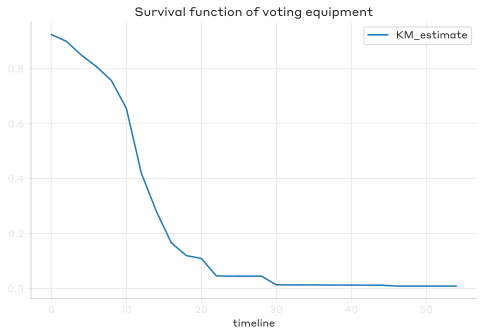

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(all['Years in Use'], event_observed=all['Final Year in Use'], weights=all['Quantity'])
kmf.survival_function_.plot()
plt.title('Survival function of voting equipment');


<Axes: xlabel='timeline'>

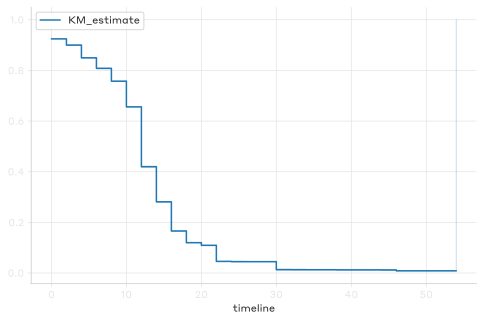

In [ ]:
kmf.plot_survival_function()

In [ ]:
time = kmf.survival_function_.index
survival_prob = kmf.survival_function_.KM_estimate

In [ ]:
from scipy.interpolate import interp1d

survival_func = interp1d(time, survival_prob, kind="linear", bounds_error=False, fill_value=(1.0, 0.0))
def hazard_func(t, survival_func, delta_time = 2):
    """
    Returns the hazard rate at time t; the probability of replacement at time t given survival until time t.
    """
    t = np.asarray(t)
    s_t = survival_func(t)
    s_t_plus = survival_func(t + delta_time)
    
    # Avoid division by zero by setting hazard to 0 where survival is 0
    with np.errstate(divide='ignore', invalid='ignore'):
        hazard = (s_t - s_t_plus) / s_t
        hazard = np.where(s_t == 0, 0.0, hazard)
    
    return hazard

hazard_func(range(0,40,2), survival_func, delta_time=2)

array([2.65688450e-02, 5.58226171e-02, 4.88943923e-02, 6.28491986e-02,
       1.33654609e-01, 3.60216044e-01, 3.30293971e-01, 4.09860292e-01,
       2.77558492e-01, 8.80262473e-02, 5.80267077e-01, 1.92321652e-02,
       2.56316362e-03, 5.62259369e-04, 7.01536737e-01, 1.80408393e-02,
       9.18614544e-03, 2.02095485e-02, 2.06263988e-02, 9.66183575e-03])

In [ ]:
start_year = 2028 # first year that equipment starts being simulated for possible replacement
end_year = 2042
delta_time = 2
years = list(range(start_year, end_year + 1, delta_time))

simulation_df = df26.copy()
simulation_df["Simulated Replaced"] = False
simulation_df["Simulated Replace Year"] = None

for year in years:
    simulation_df["Simulated Years in Use"] = year - simulation_df["First Year in Use"]

    not_replaced_yet = simulation_df[~simulation_df["Simulated Replaced"]].copy()
    n = len(not_replaced_yet)

    hazard = hazard_func(not_replaced_yet['Simulated Years in Use'], survival_func, delta_time=delta_time)
    replaced = np.random.rand(n) < hazard
    replaced_idx = not_replaced_yet.loc[replaced].index
    simulation_df.loc[replaced_idx, "Simulated Replaced"] = True
    simulation_df.loc[replaced_idx, "Simulated Replace Year"] = year
    # simulation_df.loc[replaced_idx, "First Year in Use"] = year


seems basically the same, unchnaged.
see if prep makes this different and figure out how to ahndle weights

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_62514/2270572232.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_62514/2270572232.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')


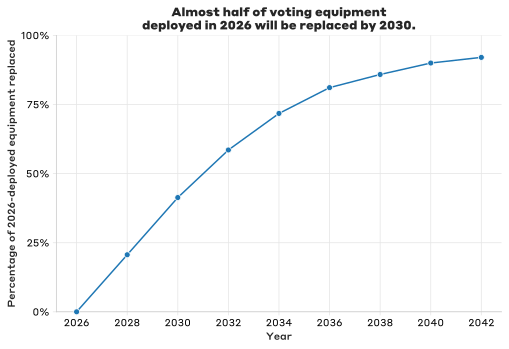

In [ ]:
axis_width = 1
sns.set_style("whitegrid", {"grid.color": ".9",
                            "font.family": "StyreneARegular",
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'xtick.bottom': True,
                            'ytick.left': True,
                            'xtick.color': '.9',
                            'ytick.color': '.9'})


cumulative_replacement_proportion = simulation_df['Simulated Replace Year'].value_counts().sort_index().cumsum() / len(simulation_df)
cumulative_replacement_proportion[2026] = 0
cumulative_replacement_proportion.sort_index(inplace=True)

sns.lineplot(data=cumulative_replacement_proportion,
             marker='o', clip_on=False, zorder=10)

plt.grid(True)
plt.ylabel('Percentage of 2026-deployed equipment replaced', fontname='StyreneAMedium')
plt.xlabel('Year', fontname='StyreneAMedium')
plt.title('Almost half of voting equipment\ndeployed in 2026 will be replaced by 2030.', fontname='StyreneABlack')

ax = plt.gca()
ax.set_xticklabels(labels=ax.get_xticklabels(), color='black')
ax.set_yticklabels(labels=ax.get_yticklabels(), color='black')
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%']);
plt.savefig('figs/replacement_simulation.png', bbox_inches='tight', dpi=dpi)

In [ ]:
rng = np.random.default_rng(42)  # reproducible

start_year = 2028  # first year that equipment starts being simulated for possible replacement
end_year = 2042
delta_time = 2
years = list(range(start_year, end_year + 1, delta_time))

simulation_df = df26.copy()

# Track units, not rows
simulation_df["Remaining Quantity"] = simulation_df["Quantity"].fillna(0).astype(int).clip(lower=0)
simulation_df["First Full Replace Year"] = pd.Series([None] * len(simulation_df), index=simulation_df.index)

# We'll accumulate replaced units per year here
replaced_units_per_year = {y: 0 for y in years}

for year in years:
    # Years in use for hazard calc
    simulation_df["Simulated Years in Use"] = year - simulation_df["First Year in Use"]

    # Only rows that still have units left
    mask_active = simulation_df["Remaining Quantity"] > 0
    active = simulation_df.loc[mask_active]

    if not active.empty:
        # Hazard per row for this step; ensure it's in [0,1]
        hazard = np.clip(hazard_func(
            active["Simulated Years in Use"],
            survival_func,
            delta_time=delta_time
        ), a_min=0, a_max=1)

        # Draw number of units replaced from remaining units (binomial)
        remaining_units = active["Remaining Quantity"].to_numpy()
        replaced_units = rng.binomial(n=remaining_units, p=hazard)

        # Write back
        simulation_df.loc[active.index, "Remaining Quantity"] = remaining_units - replaced_units

        # Tally replaced units this year
        replaced_units_per_year[year] += int(replaced_units.sum())

        # For rows that just hit zero, mark the first year they were fully replaced
        just_zero = (remaining_units > 0) & (remaining_units - replaced_units == 0)
        idx_just_zero = active.index[just_zero]
        # only fill if not already set
        not_set = simulation_df.loc[idx_just_zero, "First Full Replace Year"].isna()
        simulation_df.loc[idx_just_zero[not_set], "First Full Replace Year"] = year

# --- Build cumulative percentage replaced by units ---
total_units_2026 = simulation_df["Quantity"].fillna(0).clip(lower=0).sum()

cumulative_replacement_units = pd.Series(replaced_units_per_year).sort_index().cumsum()

# Optionally add a baseline zero at 2026 for the plot context
cumulative_replacement_units.loc[2026] = 0
cumulative_replacement_units = cumulative_replacement_units.sort_index()

cumulative_replacement_proportion = cumulative_replacement_units / max(total_units_2026, 1)

# --- Plot ---
axis_width = 1
sns.set_style("whitegrid", {"grid.color": ".9",
                            "font.family": "StyreneARegular",
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'xtick.bottom': True,
                            'ytick.left': True,
                            'xtick.color': '.9',
                            'ytick.color': '.9'})

sns.lineplot(data=cumulative_replacement_proportion,
             marker='o', clip_on=False, zorder=10)

plt.grid(True)
plt.ylabel('Percentage of 2026-deployed equipment replaced (by units)', fontname='StyreneAMedium')
plt.xlabel('Year', fontname='StyreneAMedium')
plt.title('Almost half of voting equipment\ndeployed in 2026 will be replaced by 2030.', fontname='StyreneABlack')

ax = plt.gca()
ax.set


ValueError: p < 0, p > 1 or p contains NaNs

In [ ]:
rng.binomial(n=remaining_units[:5], p=hazard[:5])



array([ 1,  5,  9,  0, 41])